# Hospital Readmissions Data Analysis and Recommendations for Reduction

### Background
In October 2012, the US government's Center for Medicare and Medicaid Services (CMS) began reducing Medicare payments for Inpatient Prospective Payment System hospitals with excess readmissions. Excess readmissions are measured by a ratio, by dividing a hospital’s number of “predicted” 30-day readmissions for heart attack, heart failure, and pneumonia by the number that would be “expected,” based on an average hospital with similar patients. A ratio greater than 1 indicates excess readmissions.

### Exercise Directions

In this exercise, you will:
+ critique a preliminary analysis of readmissions data and recommendations (provided below) for reducing the readmissions rate
+ construct a statistically sound analysis and make recommendations of your own 

More instructions provided below. Include your work **in this notebook and submit to your Github account**. 

### Resources
+ Data source: https://data.medicare.gov/Hospital-Compare/Hospital-Readmission-Reduction/9n3s-kdb3
+ More information: http://www.cms.gov/Medicare/medicare-fee-for-service-payment/acuteinpatientPPS/readmissions-reduction-program.html
+ Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet
****

In [123]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import bokeh.plotting as bkp
from scipy import stats
from mpl_toolkits.axes_grid1 import make_axes_locatable
import statsmodels.stats.api as sms

In [5]:
# read in readmissions data provided
hospital_read_df = pd.read_csv('data/cms_hospital_readmissions.csv')

In [12]:
len(hospital_read_df["Hospital Name"])

16860

In [6]:
hospital_read_df.head()

,Hospital Name,Provider Number,State,Measure Name,Number of Discharges,Footnote,Excess Readmission Ratio,Predicted Readmission Rate,Expected Readmission Rate,Number of Readmissions,Start Date,End Date
0,FROEDTERT MEMORIAL LUTHERAN HOSPITAL,520177,WI,READM-30-HIP-KNEE-HRRP,242,NaN,1.9095,10.8,5.6,38.0,07/01/2010,06/30/2013
1,PROVIDENCE HOSPITAL,90006,DC,READM-30-HIP-KNEE-HRRP,247,NaN,1.7521,9.2,5.3,33.0,07/01/2010,06/30/2013
2,BEAUFORT COUNTY MEMORIAL HOSPITAL,420067,SC,READM-30-HIP-KNEE-HRRP,586,NaN,1.5836,7.6,4.8,53.0,07/01/2010,06/30/2013
3,ADVOCATE CHRIST HOSPITAL & MEDICAL CENTER,140208,IL,READM-30-HIP-KNEE-HRRP,965,NaN,1.5760,9.0,5.7,95.0,07/01/2010,06/30/2013
4,BRAZOSPORT REGIONAL HEALTH SYSTEM,450072,TX,READM-30-HIP-KNEE-HRRP,149,NaN,1.5308,8.2,5.4,20.0,07/01/2010,06/30/2013


****
## Preliminary Analysis

In [36]:
# deal with missing and inconvenient portions of data 
clean_hospital_read_df = hospital_read_df[hospital_read_df['Number of Discharges'] != 'Not Available']
clean_hospital_read_df.loc[:, 'Number of Discharges'] = clean_hospital_read_df['Number of Discharges'].astype(int)
clean_hospital_read_df = clean_hospital_read_df.sort_values('Number of Discharges')

/Users/howellyu/anaconda/lib/python3.5/site-packages/pandas/core/indexing.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


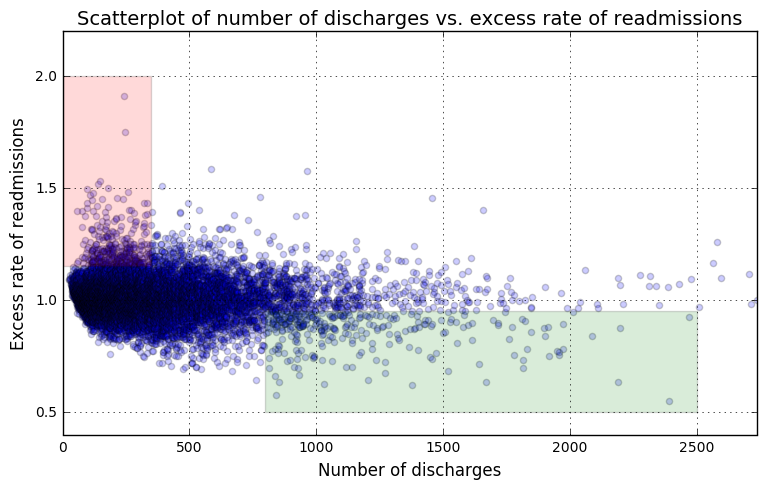

In [37]:
# generate a scatterplot for number of discharges vs. excess rate of readmissions
# lists work better with matplotlib scatterplot function
x = [a for a in clean_hospital_read_df['Number of Discharges'][81:-3]]
y = list(clean_hospital_read_df['Excess Readmission Ratio'][81:-3])

fig, ax = plt.subplots(figsize=(8,5))
ax.scatter(x, y,alpha=0.2)

ax.fill_between([0,350], 1.15, 2, facecolor='red', alpha = .15, interpolate=True)
ax.fill_between([800,2500], .5, .95, facecolor='green', alpha = .15, interpolate=True)

ax.set_xlim([0, max(x)])
ax.set_xlabel('Number of discharges', fontsize=12)
ax.set_ylabel('Excess rate of readmissions', fontsize=12)
ax.set_title('Scatterplot of number of discharges vs. excess rate of readmissions', fontsize=14)

ax.grid(True)
fig.tight_layout()

****

## Preliminary Report

Read the following results/report. While you are reading it, think about if the conclusions are correct, incorrect, misleading or unfounded. Think about what you would change or what additional analyses you would perform.

**A. Initial observations based on the plot above**
+ Overall, rate of readmissions is trending down with increasing number of discharges
+ With lower number of discharges, there is a greater incidence of excess rate of readmissions (area shaded red)
+ With higher number of discharges, there is a greater incidence of lower rates of readmissions (area shaded green) 

**B. Statistics**
+ In hospitals/facilities with number of discharges < 100, mean excess readmission rate is 1.023 and 63% have excess readmission rate greater than 1 
+ In hospitals/facilities with number of discharges > 1000, mean excess readmission rate is 0.978 and 44% have excess readmission rate greater than 1 

**C. Conclusions**
+ There is a significant correlation between hospital capacity (number of discharges) and readmission rates. 
+ Smaller hospitals/facilities may be lacking necessary resources to ensure quality care and prevent complications that lead to readmissions.

**D. Regulatory policy recommendations**
+ Hospitals/facilties with small capacity (< 300) should be required to demonstrate upgraded resource allocation for quality care to continue operation.
+ Directives and incentives should be provided for consolidation of hospitals and facilities to have a smaller number of them with higher capacity and number of discharges.

### A.
In A. Initial Observation, we does not know whether the readmission rate is trending down as the hospital capasity decreases since there is no calculation support, and visually we can hardly tell whether readmission rate goes down. 

In B. We cannot tell whether the mean of readmission rate is different for hospital with capacity > 1000 and < 100. It is necessary to run a 2 sample t test before we make any conclusion and therefore the conclusion made in C cannot be presumed correct. 

### B - 1
$H_0:$ There is NO difference of the means excess rate between hospital with capacity > 1000 and < 100. 

In [111]:
data_100 = clean_hospital_read_df[(clean_hospital_read_df['Number of Discharges'] < 100) & 
                                     (clean_hospital_read_df['Number of Discharges'] > 0)]
data_1000 = clean_hospital_read_df[clean_hospital_read_df['Number of Discharges']>1000]
mean_data_100 = data_100['Excess Readmission Ratio'].mean()
mean_data_1000 = data_1000['Excess Readmission Ratio'].mean()
var_data_100 = data_100['Excess Readmission Ratio'].var()
var_data_1000 = data_1000['Excess Readmission Ratio'].var()


print("The mean readmission rate of hospital with capacity < 100 is %.3f," 
      % round(mean_data_100, 3), "variance is %.5f,"% round(var_data_100, 5), 
      "%.2f have excess readmission rate > 1." % 
     round(len(data_100[data_100["Excess Readmission Ratio"]>1])/len(data_100["Excess Readmission Ratio"]), 2))
print("The mean readmission rate of hospital with capacity > 1000 is %.3f," 
      % round(mean_data_1000, 3), "variance is %.5f," % round(var_data_100, 5), 
     "%.2f have excess readmission rate > 1." % 
     round(len(data_1000[data_1000["Excess Readmission Ratio"]>1])/len(data_1000["Excess Readmission Ratio"]), 2)) # equal var

The mean readmission rate of hospital with capacity < 100 is 1.023, variance is 0.00336, 0.63 have excess readmission rate > 1.
The mean readmission rate of hospital with capacity > 1000 is 0.978, variance is 0.00336, 0.44 have excess readmission rate > 1.
Their difference in mean is 0.044.


The calculation above is consistent with the number provided in Preliminary Report. 

### B - 2 run 2 sample t test to compare the means

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x119759f98>]], dtype=object)

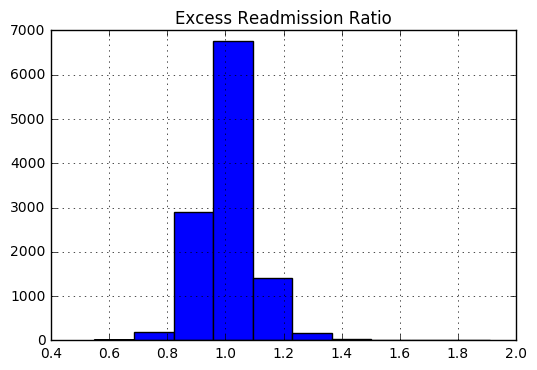

In [61]:
pd.DataFrame.hist(clean_hospital_read_df, column='Excess Readmission Ratio') # almost normal 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x119962898>]], dtype=object)

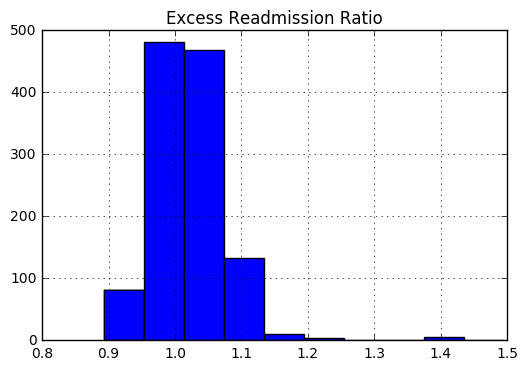

In [83]:
pd.DataFrame.hist(data_100, column='Excess Readmission Ratio') # normal

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x119981940>]], dtype=object)

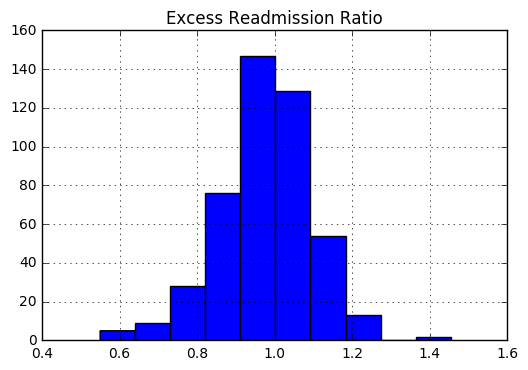

In [84]:
pd.DataFrame.hist(data_1000, column='Excess Readmission Ratio') # normal, slightly left skewed 

In [146]:
diff = mean_data_100 - mean_data_1000
t, p_value = stats.ttest_ind(data_100["Excess Readmission Ratio"], data_1000["Excess Readmission Ratio"])
print("The t score is %.3f" % round(t, 3), "and the p-value is almost %.1f" % round(p_value, 1))

cm = sms.CompareMeans(sms.DescrStatsW(data_100["Excess Readmission Ratio"]), 
                      sms.DescrStatsW(data_1000["Excess Readmission Ratio"]))
CI = cm.tconfint_diff(alpha = 0.01, usevar='unequal')
CI

The t score is 10.061 and the p-value is almost 0.0


(0.029225356358290495, 0.059340501645796843)

### B-3. 
Since p-value < 0.01, we reject the null hypothesis and conclude that there is a difference between 2 samples.

### B-4. Statistical Significant Vs. Practical Significance
Althrough the difference between 2 samples has been proved to be statistically significant, which means the will be correlation between the 2 variables, if we take a look at the confidence, we are 99% sure that the difference between the means of 2 samples will be caught between 0.029 and 0.059. Therefore, the difference is not enough to catch a true correlation in real life.

$\rightarrow$ 1. The statement "There is a significant correlation between hospital capacity (number of discharges) and readmission rates." is misleading since it does not consider the practical significance. 

$\rightarrow$ 2. The statement "Smaller hospitals/facilities may be lacking necessary resources to ensure quality care and prevent complications that lead to readmissions." may not be true since lower discharge number does not necessarily imply that the hospital is small, even though in many cases we might find this true. 

### B-5. Scatter Plot

The scatter plot provides us with direct visually aid about the data. Thus, we can have a better understanding comaring to simply look and the data frame and it is easier for us to make real-life judgement instead of getting misled by small statistical significant difference (just like in this case). However, in many other cases, a scatter plot fails to provide us a very deep understanding of the data, and without support of numbers it is very likely to make bad judgement calls. 

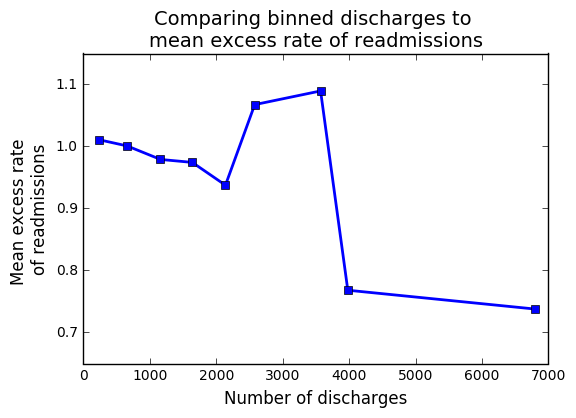

In [172]:
bins = np.linspace(clean_hospital_read_df['Number of Discharges'].min(), 
                   clean_hospital_read_df['Number of Discharges'].max(), 15)
groups = clean_hospital_read_df.groupby(np.digitize(clean_hospital_read_df['Number of Discharges'], bins))

#digitize() Return the indices of the bins to which each value in input array belongs.
plt.plot(groups.aggregate(lambda x: np.mean(x[x > 0.5]))['Number of Discharges'], 
         list(groups.aggregate(lambda x: np.mean(x[x > 0.5]))['Excess Readmission Ratio']),
         color='b', lw=2, marker='s')
plt.xlabel('Number of discharges', fontsize=12)
plt.ylabel('Mean excess rate \nof readmissions', fontsize=12)
plt.title('Comparing binned discharges to \nmean excess rate of readmissions', fontsize=14)
plt.ylim(0.65,1.15)
plt.xlim(0, 7000)
plt.show()